## GitHub Data Analysis


## Introduction
Every software engineer uses GitHub. Being a open source distributed version control tool, GitHub has thoundsands of new repositorys in every hour. Thus, GitHub could also be used as a huge dynamic data source to analyze technology status quo and trend.

In this project, we will be looking into serveral things like who is the most popular person in certain field, what is the current hottest project and how much does different programming languages being used.


### GitHub API

We will use GitHub API from [here](https://developer.github.com/v3/).
All the API calls are using HTTPS requests and it will return in JSON format.

Steps to use GitHub API:
1. Install `pygithub` by 
`-pip install pygithub`
2. Generate a GitHub Personal access token required for `GitHub API`
3. Test You API in local terminal using the following command. It is expected to return a list of dictionary contains your account info
##### - curl https://api.github.com/user\?access_token\={YOUR_TOKEN}




### NetworkX
NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. It provides tools to work with large dataset with network strucutres. With NetworkX, we can load and store neyworks in standard data format easily. It can also helps us to generate classic networks, analyze network strucutre, build network models and much more.

You can install `NetworkX` by `-pip install networkx`


In [76]:
import sys
from github import Github
import networkx as nx
from operator import itemgetter

# Global Variables
ACCESS_TOKEN = '05bb4eb867b152be20dd11f4fa292107c839931c'
USER = 'svenkreiss'  # Define the GitHub User Name
REPO = 'pysparkling'  # Define the Repo name
client = Github(ACCESS_TOKEN)
graph = nx.DiGraph()

### Set Up NetworkX Graph


After defined the user and repo name that we are going to explore, we can then set up the NetworkX graph.

We will add the repo and each user who starred the repo as nodes, and build edges between them. After this, we also add edges between users and their followers. 

In [77]:
def buildRepoRelations(REPO):
    user = client.get_user(USER)
    repo = user.get_repo(REPO)  # Get a specific repo
    REPOS = user.get_repos()
    stargazers = list(repo.get_stargazers())  # The list of users who starred this REPO
    graph.add_node(repo.name + '(repo)', type='repo', lang=repo.language, owner=user.login)
    for stargazer in stargazers:
        graph.add_node(stargazer.login + '(user)', type='user')
        graph.add_edge(stargazer.login + '(user)', repo.name + '(repo)', type='gazes')
    #	print(len(stargazers))#See if it return a correct list
    return stargazers


def buildUserRelations(stargazers):
    for i, stargazer in enumerate(stargazers):
        followers = stargazer.get_followers()
        try:
            for follower in followers:
                if follower.login + '(user)' in graph:
                    graph.add_edge(follower.login + '(user)', stargazer.login + '(user)', type='follows')
        except Exception:  
            print("Encountered an error when finding follower for user: ", stargazer.login)
        #See How many available API calls remaining
        print ("API Calls Remaining", client.rate_limiting)

In [78]:
stargazers = buildRepoRelations(REPO)
buildUserRelations(stargazers)

API Calls Remaining (3885, 5000)
API Calls Remaining (3883, 5000)
API Calls Remaining (3882, 5000)
API Calls Remaining (3881, 5000)
API Calls Remaining (3879, 5000)
API Calls Remaining (3878, 5000)
API Calls Remaining (3876, 5000)
API Calls Remaining (3875, 5000)
API Calls Remaining (3872, 5000)
API Calls Remaining (3862, 5000)
API Calls Remaining (3861, 5000)
API Calls Remaining (3832, 5000)
API Calls Remaining (3831, 5000)
API Calls Remaining (3813, 5000)
API Calls Remaining (3811, 5000)
API Calls Remaining (3809, 5000)
API Calls Remaining (3808, 5000)
API Calls Remaining (3807, 5000)
API Calls Remaining (3805, 5000)
API Calls Remaining (3765, 5000)
API Calls Remaining (3764, 5000)
API Calls Remaining (3763, 5000)
API Calls Remaining (3756, 5000)
API Calls Remaining (3754, 5000)
API Calls Remaining (3753, 5000)
API Calls Remaining (3750, 5000)
API Calls Remaining (3748, 5000)
API Calls Remaining (3732, 5000)
API Calls Remaining (3729, 5000)
API Calls Remaining (3728, 5000)
API Calls 

### Find Hottest User
In this step, we use the graph initialized above to find the hottest users. The hottest user is defined as the GitHub user followed by most of the people who starred the repo we defined previously. This can also be interpreted as those who starred this repo also follows ... 


In [79]:
from collections import Counter
from operator import itemgetter

def getHottestUser(stargazers):
    
    temp_list = []
    for edge in graph.edges(data = True):
        if edge[2]['type'] == 'follows':
            temp_list.append(edge[1])
    counter = Counter(temp_list)
    
    popular_users = []
    for u, f in counter.most_common():
        popular_users.append((u,f))
    print ("Number of popular users", len(popular_users))
    print ("Top popular users:", popular_users[:10])
    return popular_users[:10]
hottestUsers = getHottestUser(stargazers)

Number of popular users 66
Top popular users: [('svenkreiss(user)', 11), ('fonnesbeck(user)', 7), ('freeman-lab(user)', 5), ('mjhea0(user)', 4), ('Smerity(user)', 4), ('onesuper(user)', 3), ('cranmer(user)', 3), ('ajschumacher(user)', 3), ('rdhyee(user)', 2), ('esafak(user)', 2)]


The result above shows the most popular users. However, we care more about some centralities that NetworkX provided.
#### Degree Centrality
First, the Degree Centrality for a node v is the fraction of nodes it is connected to. 
#### Betweenness Centrality
Also, the Betweenness Centrality compute the shortest path for nodes. It is the sum of the fraction of all-pairs shortest paths that pass through the node v. 
#### Closeness Centrality
Lastly, the Closeness Centrality of a node u is the reciprocal of the sum of the shortest path distances from u to all n-1 other nodes. Since the sum of distances depends on the number of nodes in the graph, closeness is normalized by the sum of minimum possible distances n-1.




In [81]:
def formatResult(graph):
    graph_copy = graph.copy()
    # Remove center node
    graph_copy.remove_node('pysparkling(repo)')

    dc = sorted(nx.degree_centrality(graph_copy).items(), 
                key=itemgetter(1), reverse=True)

    bc = sorted(nx.betweenness_centrality(graph_copy).items(), 
                key=itemgetter(1), reverse=True)
    cc = sorted(nx.closeness_centrality(graph_copy).items(), 
                key=itemgetter(1), reverse=True)
    return (dc, bc, cc)

dc, bc, cc = formatResult(graph)

print ("Degree Centrality")
print (dc[:5],'\n')

print ("Betweenness Centrality")
print (bc[:5],'\n')

print ("Closeness Centrality")
print (cc[:5])

Degree Centrality
[('angusshire(user)', 0.38620689655172413), ('svenkreiss(user)', 0.10344827586206896), ('fonnesbeck(user)', 0.04827586206896552), ('esafak(user)', 0.041379310344827586), ('akansal1(user)', 0.041379310344827586)] 

Betweenness Centrality
[('angusshire(user)', 0.005842911877394636), ('svenkreiss(user)', 0.0030252234993614307), ('ajschumacher(user)', 0.0006944444444444445), ('esafak(user)', 0.0005507662835249042), ('cranmer(user)', 0.00047892720306513413)] 

Closeness Centrality
[('svenkreiss(user)', 0.0866566716641679), ('mjhea0(user)', 0.06896551724137931), ('cranmer(user)', 0.056945812807881774), ('ajschumacher(user)', 0.056945812807881774), ('castanan(user)', 0.05386766076421249)]


### Find Hottest Repository 

For the network we have currently, there is only one repo. To find the hottest repository, we need to go through each user in the network and then add their starred repos into the network. After that, it is easy for us to get the popular repositories. Moreover, we can also get to know the language preference of one certain user.

There are two input parameters of function buildRepoNet. The stargazers is the output of function buildRepoRelations which is a list of users who starred this original repo. Sometimes a user marks too many repos and it takes a lot of time to build the net. So here the limit_repo parameter could define the maximum of the repos of one user we need to add into the net. 

In [82]:
def buildRepoNet(stargazers, limit_repo):
    for i, v in enumerate(stargazers):
        print(v.login)
        try:
            for starred in v.get_starred()[:limit_repo]:  # Slice to avoid supernodes
                graph.add_node(starred.name + '(repo)', type='repo', lang=starred.language, \
                           owner=starred.owner.login)
                graph.add_edge(v.login + '(user)', starred.name + '(repo)', type='gazes')
        except Exception:  # ssl.SSLError:
            print("Encountered an error fetching starred repos for", v.login, "Skipping.")

        print("Num nodes/edges in graph", graph.number_of_nodes(), "/", graph.number_of_edges())
    print(nx.info(graph), '\n')


Here we define the number of limit_repo as 200. It takes about 10 minutes to generate the repo net. The total number of nodes is 15696 and the total number of edges is 22100.

In [85]:
buildRepoNet(stargazers,200)

he0x
Num nodes/edges in graph 357 / 467
nschlemm
Num nodes/edges in graph 557 / 667
cheekybastard
Num nodes/edges in graph 755 / 867
ddboline
Num nodes/edges in graph 947 / 1066
dclambert
Num nodes/edges in graph 1133 / 1266
emlazzarin
Num nodes/edges in graph 1315 / 1461
mvaz
Num nodes/edges in graph 1503 / 1659
Veallym0n
Num nodes/edges in graph 1551 / 1709
svenkreiss
Num nodes/edges in graph 1695 / 1877
ajschumacher
Num nodes/edges in graph 1879 / 2076
akansal1
Num nodes/edges in graph 2051 / 2276
fonnesbeck
Num nodes/edges in graph 2214 / 2475
vasudevram
Num nodes/edges in graph 2392 / 2671
freeman-lab
Num nodes/edges in graph 2578 / 2871
StephanErb
Num nodes/edges in graph 2758 / 3070
juanshishido
Num nodes/edges in graph 2916 / 3269
dylanroy
Num nodes/edges in graph 3094 / 3468
gawry
Num nodes/edges in graph 3266 / 3668
denisfitz57
Num nodes/edges in graph 3449 / 3867
mjhea0
Num nodes/edges in graph 3626 / 4067
ronert
Num nodes/edges in graph 3768 / 4265
jchaat
Num nodes/edges in

Next, we can use the builded net to get the popular repos. The more users star the repo, the more popular it is. So here we iterate each repo node in the graph and record the hit times.

In [86]:
def getTopNRepos(n):
    print("Top "+ str(n) + " Popular repositories:")
    
    repos = []
    for (v, i) in graph.in_degree():
        if graph.node[v]['type'] == 'repo':
            repos.append((v,i))
    repos = sorted(repos, key = lambda x:x[1], reverse=True)
    return repos[:n]

Let's try to get the top 10 popular repositories.

In [87]:
hottestRepos = getTopNRepos(10)
print(hottestRepos)

Top 10 Popular repositories:
[('pysparkling(repo)', 146), ('spark(repo)', 30), ('tensorflow(repo)', 23), ('dask(repo)', 19), ('incubator-superset(repo)', 18), ('jupyterlab(repo)', 17), ('awesome-machine-learning(repo)', 17), ('models(repo)', 17), ('keras(repo)', 16), ('awesome-python(repo)', 16)]


With this net, we can also get the one certain user's preference such as the repositories and the interested languages.

In [88]:
def getPreferRepos(username):
    
    repos = []
    for v in graph[username+"(user)"]:
        if graph[username+"(user)"][v]['type'] == 'gazes':
            repos.append(v)
    return repos

In [89]:
def getPreferLanguages(username):
      
    langs = set()
    for v in graph[username+"(user)"]:
        if graph[username+"(user)"][v]['type'] == 'gazes':
            langs.add(graph.node[v]['lang'])
    return langs

Here we can check the preference of the hottest user we find above.

In [90]:
print(hottestUsers[0][0])
user = hottestUsers[0][0].split('(')[0]
print("Respositories that "+user+ " has starred")
repos = getPreferRepos(user)
print(repos)
print("Programming languages "+user+ " is interested in")  
langs = getPreferLanguages(user)
print(langs)

svenkreiss(user)
Respositories that svenkreiss has starred
['read-this-first(repo)', 'playground(repo)', 's2sphere(repo)', 'gradient-checkpointing(repo)', 'Theano(repo)', 'localcrawl(repo)', 'fcl(repo)', 'moby(repo)', 'kaggle-galaxies(repo)', 'sumo-web3d(repo)', 'videogan(repo)', 'DeepMind-Atari-Deep-Q-Learner(repo)', 'dvds-js(repo)', 'models(repo)', 'meeting-room-tablet(repo)', 'caffe(repo)', 'neuraltalk(repo)', 'hue(repo)', 'pelican_dynamic(repo)', 'rc-data(repo)', 'statsd(repo)', 'deepdive(repo)', 'docker-flask-gevent(repo)', 'protractor(repo)', 'redis-commander(repo)', 'skip-thoughts(repo)', 'bazel(repo)', 'keras-js(repo)', 'ttk(repo)', 'pytorch(repo)', 's2geometry(repo)', 'spark(repo)', 'snappy(repo)', 'ipfs(repo)', 'pelican_plugin-render_math(repo)', 'scikit-learn(repo)', 'tensorflow(repo)', 'jedi(repo)', 'cayley(repo)', 'keras-GAN(repo)', 'kubernetes(repo)', 'decoupledDemo(repo)', 'keras(repo)', 'opencv(repo)', 'textwrangler-bbedit-solarized(repo)', 'cpython(repo)', 'grumpy(repo

Correspondingly, we can also get the list of users who star one certain repo.

In [91]:
def getStarredUser(repoName):
    users = []
    for (v, i) in graph.in_degree():
        if graph.node[v]['type'] == 'user':
            if repoName+"(repo)" in getPreferRepos(v.split('(')[0]):
                users.append(v)
    return users

For the hottest repo, we can also get the list of user who have starred the repo.

In [92]:
repo = hottestRepos[0][0].split('(')[0]
users = getStarredUser(repo)
print(users)
print(len(users))

['ajlmsbux(user)', 't0n1c(user)', 'ekampf(user)', 'rushter(user)', 'tedmiston(user)', 'pbamotra(user)', 'hezila(user)', 'nabilm(user)', 'wuxianliang(user)', 'Stardust1002(user)', 'brianv0(user)', 'ronert(user)', 'craigwilkins(user)', 'johanfforsberg(user)', 'waxz(user)', 'ptrf(user)', 'farquasar1(user)', 'mtpatter(user)', 'imrv13(user)', 'onesuper(user)', 'amelio-vazquez-reina(user)', 'rgabo(user)', 'jgmize(user)', 'kmatt(user)', 'xrbu(user)', 'jessem(user)', 'emlazzarin(user)', 'sevenguin(user)', 'Syrus(user)', 'dylanroy(user)', 'hhstore(user)', 'ysku(user)', 'lomereiter(user)', 'wangdi244(user)', 'SummerTea(user)', 'rdhyee(user)', 'miniaturelle(user)', 'tcoyze(user)', 'ansrivas(user)', 'petrushy(user)', 'skribled(user)', 'telamonian(user)', 'juanshishido(user)', 'xinyu-usf(user)', 'freegnu(user)', 'basilhe(user)', 'ddboline(user)', 'ZhukovAlexander(user)', 'walkersuen(user)', 'aalhour(user)', 'ziedzic(user)', 'XIEQ(user)', 'binh-vu(user)', 'aleury(user)', 'qiwihui(user)', 'wearpants(

Using the two functions above, we can do some further analysis about the relationship between some hot topics. For each pair of repos, we can count how many people star both two repos? 

In [93]:
def repoRelationship(repo1, repo2):
    user1 = getStarredUser(repo1)
    user2 = getStarredUser(repo2)
    commonUser = set(user1)&set(user2)
    p1 = len(commonUser)/len(user1)
    p2 = len(commonUser)/len(user2)
    return (p1,p2)

To get the visible result, we use library seaborn to create a heatmap.

In [94]:
import seaborn as sns # for Interactive plots
import matplotlib.pyplot as plt # for plots
% matplotlib inline
import pandas as pd
import numpy as np

def repoHeatMap(repos):
    length = len(repos)
    x = np.zeros((length,length))
    columns = list(map(lambda x:x[0].split('(')[0],repos))
    print(columns)
    for i,v in enumerate(columns):
        for j in range(i,length):
            p1,p2 = repoRelationship(v,columns[j])
            x[i][j] = p1
            x[j][i] = p2
    df = pd.DataFrame(x,columns = columns)
    sns.heatmap(df,annot=True)
#     plt.figure(figsize=(12,10))
    plt.xticks(rotation=75)
    plt.show()

We use the top ten hottest repos to create the heatmap.

['pysparkling', 'spark', 'tensorflow', 'dask', 'incubator-superset', 'jupyterlab', 'awesome-machine-learning', 'models', 'keras', 'awesome-python']


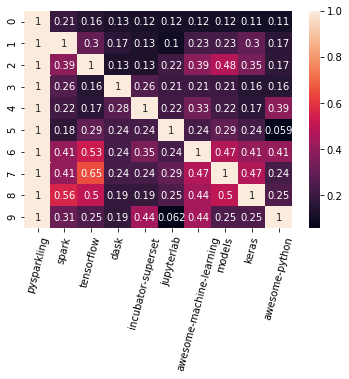

In [95]:
repoHeatMap(hottestRepos)

### Find Hot Programming Language

What if we want to know which is the most popular language for all projects in the current map we generated? We can go through the projects and then extract the language part and put it into the counter to count, this seems easy to do, but what if we want to query how many users are programming in a particular kind of language? This requires scanning the in-degree users of each project, and finally summing up the count results. This idea requires large time complexity. A good idea at this time is to expand the map and use the language as a single node. The logic diagram of the final map is as follows:

[<img src="https://raw.githubusercontent.com/hanna1994/han1994/master/191525762986_.pic_hd.jpg",width=400, height=400>](https://raw.githubusercontent.com/hanna1994/han1994/master/191525762986_.pic_hd.jpg)

In [96]:
def createlanguagemap():
    repos = []
  
    for n in graph.nodes():
        if graph.node[n]['type'] == 'repo':
            repos.append(n)

    for repo in repos:
        # some empty projects may have none of the language part
#         lang = (graph.node_iter[repo]['lang'] or "") + "(lang)"
        if graph.node[repo]['lang']:
            lang = (graph.node[repo]['lang']) + "(lang)"
        else:
            lang = ("") + "(lang)"
        # users who gazed repo

        stargazers = []

        for (user, repo, data) in graph.in_edges(repo, data=True):
            if data['type'] == 'gazes':
                stargazers.append(user)

        for stargazer in stargazers:
            graph.add_edge(stargazer, lang, type='programs')
            graph.add_node(lang, type='lang')
            graph.add_edge(lang, repo, type='implements')  

Then, let's see the count results of the languages. First we should see what languages are there in the map:

In [97]:
createlanguagemap()
# let us see what languages are in the map
ral = []
for n in graph.nodes():
    if graph.node[n]['type'] == 'lang':
        ral.append(n)
print(ral)   

['Racket(lang)', 'Dart(lang)', 'PureScript(lang)', 'HCL(lang)', 'Vue(lang)', 'Ragel in Ruby Host(lang)', 'PLpgSQL(lang)', 'Roff(lang)', 'M4(lang)', 'CSS(lang)', 'Frege(lang)', 'C(lang)', 'Nginx(lang)', 'Ruby(lang)', 'Nimrod(lang)', 'CWeb(lang)', 'MQL5(lang)', 'Rust(lang)', 'PowerShell(lang)', 'Awk(lang)', 'Scilab(lang)', 'IDL(lang)', 'ANTLR(lang)', 'R(lang)', 'Jupyter Notebook(lang)', 'F#(lang)', 'Swift(lang)', 'Java(lang)', 'Elm(lang)', 'TLA(lang)', 'Visual Basic(lang)', 'C++(lang)', 'Makefile(lang)', 'Pascal(lang)', 'Assembly(lang)', 'Julia(lang)', 'Groff(lang)', 'Coq(lang)', 'SystemVerilog(lang)', 'C#(lang)', 'Common Lisp(lang)', 'Thrift(lang)', 'VHDL(lang)', 'CoffeeScript(lang)', 'Agda(lang)', 'PHP(lang)', 'DIGITAL Command Language(lang)', 'Clojure(lang)', 'Protocol Buffer(lang)', 'Go(lang)', 'Puppet(lang)', 'Scala(lang)', 'Smarty(lang)', 'WebAssembly(lang)', 'Web Ontology Language(lang)', 'Kotlin(lang)', 'Mathematica(lang)', 'PureBasic(lang)', 'Crystal(lang)', 'Stan(lang)', 'Fortr

Now we can see the top 10 hottest languages users are using:

In [98]:
# find hottest 10 languages
def tenanguages():
    print ("Most popular languages")
    print (sorted([(n, graph.in_degree(n))
     for n in graph.nodes() 
         if graph.node[n]['type'] == 'lang'], key=itemgetter(1), reverse=True)[:10])

In [99]:
tenanguages()

Most popular languages
[('Python(lang)', 146), ('(lang)', 133), ('JavaScript(lang)', 133), ('Java(lang)', 128), ('C++(lang)', 128), ('Jupyter Notebook(lang)', 125), ('C(lang)', 123), ('HTML(lang)', 121), ('Shell(lang)', 115), ('Go(lang)', 105)]


And let us see some common languages usage:

In [100]:
# find how many people are using the certain kind of language
def languageusage(languageType):
    languser = []
    for (user, lang) in graph.in_edges(languageType):
         if graph.node[user]['type'] == 'user':
                languser.append(user)
    return languser

In [101]:
pythonuser = languageusage('Python(lang)')
jsuser = languageusage('JavaScript(lang)')
ruser = languageusage('R(lang)')
cuser = languageusage('C(lang)')
cplususer = languageusage('C++(lang)')
cssuser = languageusage('CSS(lang)')
htmluser = languageusage('HTML(lang)')
phpuser = languageusage('PHP(lang)')

print ("Number of Python programmers:", len(pythonuser))
print ("Number of JavaScript programmers:", len(jsuser))
print ("Number of R programmers:", len(ruser))
print("--------------------------------------------------------")
print ("Number of C programmers:", len(cuser))
print ("Number of C++ programmers:", len(cplususer))
print("--------------------------------------------------------")
print ("Number of CSS programmers:", len(cssuser))
print ("Number of HTML programmers:", len(htmluser))
print ("Number of PHP programmers:", len(phpuser))

Number of Python programmers: 146
Number of JavaScript programmers: 133
Number of R programmers: 54
--------------------------------------------------------
Number of C programmers: 123
Number of C++ programmers: 128
--------------------------------------------------------
Number of CSS programmers: 93
Number of HTML programmers: 121
Number of PHP programmers: 51


for the most languages people used: pyhton and js, we also analyzed the intersection of these two languages:

In [102]:
def compareJSwithPy(js,py):
    # people who use both languages
    print ("Number of programmers who use js and Py:")
    print (len(set(js).intersection(set(py))))

    # people who only use python but not js
    print ("Number of programmers who use Py but not Js:")
    print (len(set(py).difference(set(js))))
    
    # people who only use js but not py
    print ("Number of programmers who use js but not py:")
    print (len(set(js).difference(set(py))))

In [103]:
compareJSwithPy(pythonuser,jsuser)

Number of programmers who use js and Py:
133
Number of programmers who use Py but not Js:
0
Number of programmers who use js but not py:
13


Wala! Now we can analyze the results! It can be seen from the results that JS and R, python and other scripting languages in github's preferred language list occupy the mainstream. Although there are only 10,000 items involved in the data we analyzed, it is like the old saying: “github is the world of front end”.

What's more, Scala is also very hot from seeing our results, mainly because the "source of the project" is findspark.

Another interesting phenomenon is that the programmers who use python definetly will use js, and those who use js  will not necessarily use python (80-74=6 individuals who is using js but not using python).

### visialize the relationship between the users and languages

In [104]:
import os
import json
from IPython.display import IFrame
from IPython.core.display import display 
from networkx.readwrite import json_graph
print ("Stats on the full graph" )
print (nx.info(graph))
# extract users and language info
mtsw_users = [n for n in graph if graph.node[n]['type'] == 'user'] +[n for n in graph if graph.node[n]['type'] == 'lang'] 
h = graph.subgraph(mtsw_users)
print ("Stats on the extracted subgraph" )
print (nx.info(h))
# export json
d = json_graph.node_link_data(h)
json.dump(d, open('githubd3.json', 'w'))
viz_file = 'githubd3.html'
# D3 to visulize it
display(IFrame(viz_file, '100%', '900px'))

Stats on the full graph
Name: 
Type: DiGraph
Number of nodes: 15820
Number of edges: 40315
Average in degree:   2.5484
Average out degree:   2.5484
Stats on the extracted subgraph
Name: 
Type: SubDiGraph
Number of nodes: 270
Number of edges: 2776
Average in degree:  10.2815
Average out degree:  10.2815
